# Predicting the occupancies of Belgian trains

In [236]:
#vector/matrix library
import numpy as np
#data frame library (similar to R)
import pandas as pd

#visualization library
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#regular expression library for data cleasning
import re

## 3. Building a basic forecasting model

### 3.1 Create a simple Kaggle submission

1. Create a csv document, just like the random.csv, submit to kaggle and try to get to the baseline performance in the leaderboard
2. **OPTIONAL:** what performance can you get by making a manually crafted rule-based prediction?

In [237]:
#1
dataset = pd.read_csv('json_cleaned.csv')

dataset['querytime'] = pd.to_datetime(dataset['querytime'])

mask = dataset['id'] < 0

training_set = dataset[mask]
test_set = pd.DataFrame(dataset[~mask])

In [238]:
test_set['occupancy']=0
test_set['id'] = pd.to_numeric(test_set['id'], downcast='integer')
test_set['occupancy'] = pd.to_numeric(test_set['occupancy'], downcast='integer')

submission = test_set.drop(['querytime', 'to', 'from', 'train_series', 'train_direction', 'train_type'], axis=1)
submission.to_csv('constant_submission.csv', index=False)

### 3.2 Creating Numerical Features for sklearn

As mentioned in the theory slides: machine learning models can only deal with numerical data. In what follows we'll prepare a minimal dataframe and convert it to numpy arrays (which serve as input to an ML model)

Sklearn follows a very simple approach: http://scikit-learn.org/stable/data_transforms.html

- Estimators, have a fit method, which learns model parameters from a dataset
- Transformers have a transform method which applies this transformation model to unseen data. Making a prediction is considered a transformation, but also scaling the data for example!
- fit_transform combines the above
    
    
1. Prepare a dataframe with train_type, direction and a number of time series features (see EDA notebook). Make sure the data is scaled (for better model performance) and encode all categorical variables. Use the methods which are imported from the sklearn.preprocessing module

2. Split back into train and test and convert the dataframes to nd.array   



In [239]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [240]:
#create additional time features: month, weekday, hour,... => some inspiration from the EDA notebook?
dataset_prep1 = dataset.drop(['to','from'], axis=1)
dataset_prep1['month']   = dataset['querytime'].apply(lambda d: d.month)
dataset_prep1['hour']    = dataset['querytime'].apply(lambda d: d.hour)
dataset_prep1['weekday'] = dataset['querytime'].apply(lambda d: d.weekday())
dataset_prep1['workday']  = dataset_prep1['weekday'].apply(lambda d: 1 if d<5 else 0)
dataset_prep1['saturday'] = dataset_prep1['weekday'].apply(lambda d: 1 if d==5 else 0)
dataset_prep1['sunday']   = dataset_prep1['weekday'].apply(lambda d: 1 if d==6 else 0)
dataset_prep2 = dataset_prep1.drop(['querytime', 'train_series', 'weekday'], axis=1)
dataset_prep2



,id,occupancy,train_direction,train_type,month,hour,workday,saturday,sunday
0,-1,high,away,IC,7,21,1,0,0
1,-1,low,back,IC,7,22,1,0,0
2,-1,low,back,IC,7,22,1,0,0
3,-1,high,back,IC,7,22,1,0,0
4,-1,medium,away,IC,7,6,1,0,0
5,-1,low,back,S,7,7,1,0,0
6,-1,medium,away,IC,7,7,1,0,0
7,-1,medium,away,IC,7,7,1,0,0
8,-1,low,away,ICT,7,8,1,0,0
9,-1,low,away,ICT,7,8,1,0,0


In [241]:
#encode train_direction
le = LabelEncoder()
#train direction
dataset_prep2['train_direction'] = le.fit_transform(dataset['train_direction'])
dataset_prep2.head(n=3)

,id,occupancy,train_direction,train_type,month,hour,workday,saturday,sunday
0,-1,high,0,IC,7,21,1,0,0
1,-1,low,1,IC,7,22,1,0,0
2,-1,low,1,IC,7,22,1,0,0


In [242]:
#map occupancies from [low, medium, high] -> [0,1,2]

def occupancy_to_number(r):
    if r == 'low': 
        return 0 
    elif r == 'medium': 
        return 1 
    elif r == 'high':
        return 2
    else:
        return None
    
    
dataset_prep2['occupancy'] = dataset_prep2['occupancy'].apply(occupancy_to_number)
dataset_prep2.head(n=3)

,id,occupancy,train_direction,train_type,month,hour,workday,saturday,sunday
0,-1,2.0,0,IC,7,21,1,0,0
1,-1,0.0,1,IC,7,22,1,0,0
2,-1,0.0,1,IC,7,22,1,0,0


In [243]:
#have a look at the pandas get dummies function, it converts categorical data into a numerical presentation...

df_vehicle_type = pd.get_dummies(dataset_prep2['train_type'], prefix='f_vehicle')
df_vehicle_type.head(n=3)

,f_vehicle_BUS,f_vehicle_EUR,f_vehicle_EXT,f_vehicle_IC,f_vehicle_ICE,f_vehicle_ICT,f_vehicle_L,f_vehicle_P,f_vehicle_S,f_vehicle_TGV,f_vehicle_THA,f_vehicle_TRN
0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0


In [244]:
dataset_prep3 = pd.DataFrame(pd.concat([dataset_prep2, df_vehicle_type],axis=1))
dataset_prep4 = dataset_prep3.drop('train_type', axis=1)
dataset_prep4

,id,occupancy,train_direction,month,hour,workday,saturday,sunday,f_vehicle_BUS,f_vehicle_EUR,f_vehicle_EXT,f_vehicle_IC,f_vehicle_ICE,f_vehicle_ICT,f_vehicle_L,f_vehicle_P,f_vehicle_S,f_vehicle_TGV,f_vehicle_THA,f_vehicle_TRN
0,-1,2.0,0,7,21,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,-1,0.0,1,7,22,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,-1,0.0,1,7,22,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,-1,2.0,1,7,22,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,-1,1.0,0,7,6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5,-1,0.0,1,7,7,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6,-1,1.0,0,7,7,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7,-1,1.0,0,7,7,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,-1,0.0,0,7,8,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9,-1,0.0,0,7,8,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [245]:
#scale the time features for better model performance

minmax = MinMaxScaler()

dataset_prep4.loc[:,['month','hour']] = minmax.fit_transform(dataset_prep4[['month', 'hour']])
dataset_prep4.head(n=5)

,id,occupancy,train_direction,month,hour,workday,saturday,sunday,f_vehicle_BUS,f_vehicle_EUR,f_vehicle_EXT,f_vehicle_IC,f_vehicle_ICE,f_vehicle_ICT,f_vehicle_L,f_vehicle_P,f_vehicle_S,f_vehicle_TGV,f_vehicle_THA,f_vehicle_TRN
0,-1,2.0,0,0.545455,0.913043,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,-1,0.0,1,0.545455,0.956522,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,-1,0.0,1,0.545455,0.956522,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,-1,2.0,1,0.545455,0.956522,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,-1,1.0,0,0.545455,0.260870,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [246]:
#separate train from test
mask = dataset_prep4['id'] < 0

training_set = pd.DataFrame(dataset_prep4[mask]).drop('id', axis=1)
test_set = pd.DataFrame(dataset_prep4[~mask])

In [247]:
training_set.head(n=3)

,occupancy,train_direction,month,hour,workday,saturday,sunday,f_vehicle_BUS,f_vehicle_EUR,f_vehicle_EXT,f_vehicle_IC,f_vehicle_ICE,f_vehicle_ICT,f_vehicle_L,f_vehicle_P,f_vehicle_S,f_vehicle_TGV,f_vehicle_THA,f_vehicle_TRN
0,2.0,0,0.545455,0.913043,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0.0,1,0.545455,0.956522,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0.0,1,0.545455,0.956522,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [248]:
test_set.head(n=3)

,id,occupancy,train_direction,month,hour,workday,saturday,sunday,f_vehicle_BUS,f_vehicle_EUR,f_vehicle_EXT,f_vehicle_IC,f_vehicle_ICE,f_vehicle_ICT,f_vehicle_L,f_vehicle_P,f_vehicle_S,f_vehicle_TGV,f_vehicle_THA,f_vehicle_TRN
4970,0,NaN,1,0.181818,0.391304,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4971,1,NaN,0,0.181818,0.434783,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4972,2,NaN,0,0.181818,0.434783,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [249]:
training_matrix = training_set.values
test_matrix = test_set.drop(['id','occupancy'], axis=1).values

### 3.3 First Submission - Simple Linear Regression

In [250]:
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()

X_train = training_set.drop(['occupancy'], axis=1).values
y_train = training_set['occupancy'].values



In [251]:
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [252]:
X_test = test_matrix
y_test = lin_reg.predict(X_test)

In [253]:
test_set['occupancy'] = y_test

def occ_to_int(o):
    if o > 1.20:
        return 2
    elif o < 0.80:
        return 0
    else:
        return 1

test_set['occupancy'] = test_set['occupancy'].apply(occ_to_int)

In [254]:
test_set['occupancy'].value_counts()

1    394
0     98
2      1
Name: occupancy, dtype: int64

In [255]:
test_set.head(n=3)

,id,occupancy,train_direction,month,hour,workday,saturday,sunday,f_vehicle_BUS,f_vehicle_EUR,f_vehicle_EXT,f_vehicle_IC,f_vehicle_ICE,f_vehicle_ICT,f_vehicle_L,f_vehicle_P,f_vehicle_S,f_vehicle_TGV,f_vehicle_THA,f_vehicle_TRN
4970,0,1,1,0.181818,0.391304,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4971,1,1,0,0.181818,0.434783,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4972,2,1,0,0.181818,0.434783,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [256]:
test_set['id'] = pd.to_numeric(test_set['id'], downcast='integer')
test_set['occupancy'] = pd.to_numeric(test_set['occupancy'], downcast='integer')

submission = test_set[['id','occupancy']]
submission.to_csv('slr.csv', index=False)

### 3.4 Offline Model Evaluation

1. Make a (manual) Train / Test split 
    * First 90% of the training data is used for model training, the remainder is used for model evaluation
    * (K-fold cross validation is more common, do you have an idea why it might not be appropriate here?)
2. To evaluate the basic model, plot the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html"> confusion matrix </a> and caculate the accuracy
3. Test the previous model for different values of the hyperparameter
4. Try a number of different approaches, for example a <a href="http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html"> k-Nearest Neighbours </a> classifier, definitely also have a look at a tree-based approach: <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html"> Random Forest Classifier </a>
5. Which of these models has the highest prediction accuracy? Are they complementary or do their correct predictions mostly overlap? (complementary models can be good candidates for building <a href="http://scikit-learn.org/stable/modules/ensemble.html">ensembles </a>)

6. Next steps for the quick students: 
    * use station locations and merge with to, from columns: stations.csv
    * use line stops: lineinfo.csv
    * look for holiday information

In [257]:
#1 train test

X_tr = X_train[:4500]
y_tr = y_train[:4500]
X_te  = X_train[4501:]
y_te  = y_train[4501:]

In [258]:
#2
from sklearn.metrics import confusion_matrix

In [259]:
lin_reg.fit(X_tr, y_tr)
y_pred = lin_reg.predict(X_te)

In [260]:
y_pred1 = pd.Series(y_pred).apply((occ_to_int)).values
y_pred1

confusion = confusion_matrix(y_te, y_pred1)
confusion.sum()
confusion = confusion / confusion.sum()

([<matplotlib.axis.YTick at 0x7f8a33bd3b00>,
 <a list of 3 Text yticklabel objects>)

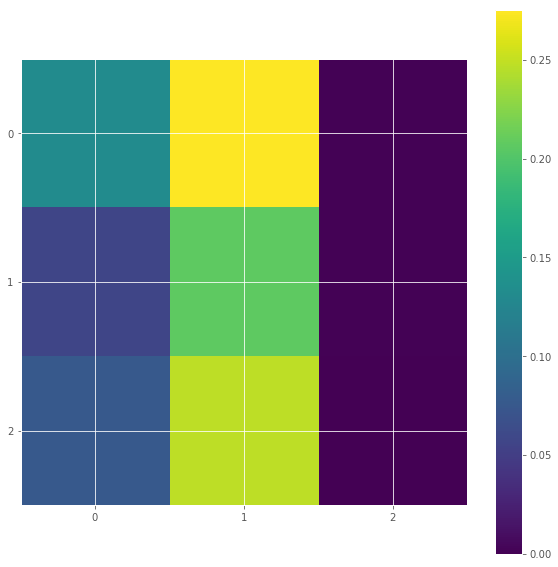

In [261]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
cax = ax.imshow(confusion)
fig.colorbar(cax)
plt.xticks([0,1,2])
plt.yticks([0,1,2])


In [262]:
from sklearn.metrics import accuracy_score

accuracy_score(y_te, y_pred1)


#grid search
#learning curves

0.33901918976545842

In [263]:
#regression - lasso regression
#NN classifier

In [264]:
#4

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_tr, y_tr)
y_pred = neigh.predict(X_te)

In [265]:
accuracy_score(y_te, y_pred)


0.43710021321961623

In [266]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_tr, y_tr)
y_pred = neigh.predict(X_te)
accuracy_score(y_te, y_pred)


0.38379530916844351

In [267]:
from sklearn.ensemble import RandomForestClassifier

In [270]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_tr, y_tr)
y_rf = rf.predict(X_te)
accuracy_score(y_te, y_rf)


0.43496801705756932

In [271]:
#5
df_complementary = pd.DataFrame([y_pred, y_pred1, y_rf,  y_te]).T

In [272]:
df_complementary.columns = ['nn3', 'slr', 'rf', 'solution']

In [273]:
df_complementary

,nn3,slr,rf,solution
0,2.0,1.0,2.0,2.0
1,1.0,1.0,1.0,2.0
2,1.0,1.0,1.0,2.0
3,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0
6,0.0,1.0,0.0,1.0
7,1.0,1.0,1.0,1.0
8,0.0,1.0,0.0,0.0
9,2.0,1.0,2.0,0.0


In [276]:
nn3correct = df_complementary['nn3'] == df_complementary['solution']
slrcorrect = df_complementary['slr'] == df_complementary['solution']
rfcorrect = df_complementary['rf'] == df_complementary['solution']

In [281]:
print(df_complementary.shape[0])
print()
print(df_complementary[nn3correct].shape[0])
print(df_complementary[slrcorrect].shape[0])
print(df_complementary[rfcorrect].shape[0])
print()
print(df_complementary[slrcorrect & rfcorrect].shape[0])
print(df_complementary[rfcorrect & nn3correct].shape[0])


469

213
159
204

72
201
